In [234]:
#importes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler 

#dcs techniques
from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.des import DESP

from deslib.des import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des import KNOP
from deslib.des import METADES
# stacked model
from deslib.static import (StackedClassifier,
                           SingleBest,
                           StaticSelection)



from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score



In [235]:
def salvar_grafico(metricas, int_conf):
    
    for m in metricas.columns:
        fig, bx = plt.subplots()
        width=0.5
        clf = ['Single Best', 'Static Selection', 'Stacked','KNORA-U', 'KNORA-E', 'DES-P', 'OLA', 'MCB', 'KNOP', 'META-DES']
        plt.title("{} (%)".format(m))
        plt.gca().invert_yaxis()
        bx.barh(clf, width, xerr=int_conf.loc[:, m])  
        for i, v in enumerate(metricas.loc[:, m]):
            if m == 'FPR':
                bx.xaxis.set_ticks(np.arange(0, 10, 5)) #sem clus
                plt.text(v + 3, i + 0.1, str(v))
            elif m == 'FNR':
                bx.xaxis.set_ticks(np.arange(0, 10, 5)) #sem clus
                plt.text(v + 3, i + 0.1, str(v))
            else:
                bx.xaxis.set_ticks(np.arange(0, 110, 10))
                plt.text(v + 1.5, i + 0.1, str(v), color="blue")
        plt.savefig(r'C:\Users\anali\OneDrive\Documentos\Faculdade\TCC\Treinamento2\Metricas\sem_clus\{}.png'.format(m), bbox_inches="tight", dpi=150)

def gerar_csv(dataframe_metrica):
    colunas = ['Single Best', 'Static Selection', 'Stacked','KNORA-U', 'KNORA-E', 'DES-P', 'OLA', 'MCB', 'KNOP', 'META-DES']
    metricas = ['Acurácia', 'F1', 'G-mean', 'Precisão', 'FPR', 'FNR', 'Sensibilidade', 'Especificidade']
    for m in metricas:
        dataframe_metrica.columns = colunas
        dataframe_metrica.to_csv(r'C:\Users\anali\OneDrive\Documentos\Faculdade\TCC\Treinamento2\Avaliacao\Dados{}.csv'.format(m), index=False, header=True)

In [236]:
#Ler o arquivo CSV
archive_name = pd.read_csv('DrDoS_MSSQL.csv')

archive_name.head()

,Flow Packets/s,Label,Protocol
0,0.0,0.0,0.0
1,1.0,0.0,17.0
2,1.0,0.0,17.0
3,2.0,0.0,17.0
4,2.0,0.0,17.0


In [237]:
#altera as posiçoes das colunas
new_ord = [0,2,1]
archive_names = archive_name[archive_name.columns[new_ord]]
archive_names.head()

,Flow Packets/s,Protocol,Label
0,0.0,0.0,0.0
1,1.0,17.0,0.0
2,1.0,17.0,0.0
3,2.0,17.0,0.0
4,2.0,17.0,0.0


In [238]:
# Separação de atributos e labels
X = archive_names.iloc[:, 0:2].values
Y = archive_names.iloc[:, [2]].values

In [239]:
print(X)
print("--------")
print(Y)

[[ 0.  0.]
 [ 1. 17.]
 [ 1. 17.]
 ...
 [ 1. 17.]
 [ 1. 17.]
 [ 1. 17.]]
--------
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [240]:
# fit predictor and target variable (balanceamento)
rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X,Y)

In [241]:
print(len(x_rus))
print(len(y_rus))

4012
4012


In [242]:
# dividir os dados em dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.6, random_state=0)

pool_classifiers = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                     n_estimators=200)
pool_classifiers.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200)

In [243]:
#Instanciamento dos classificadores
# Configurando métodos estáticos.

stacked = StackedClassifier(pool_classifiers)
static_selection = StaticSelection(pool_classifiers)
single_best = SingleBest(pool_classifiers)

#Técnica DS. Aqui especificamos o tamanho de a região de competência (5 vizinhos)

knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
knop = KNOP(pool_classifiers)
meta = METADES(pool_classifiers)


metodos2 = ['Single Best', 'Static Selection', 'Stacked','KNORA-U', 'KNORA-E', 'DES-P', 'OLA', 'MCB', 'KNOP', 'META-DES']

metodos = [single_best, static_selection, stacked,
           knorau, kne, desp, ola, mcb, knop, meta]

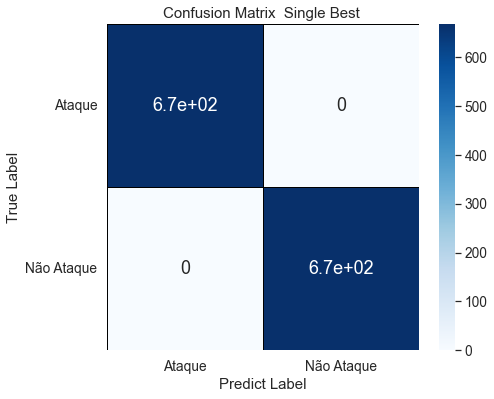

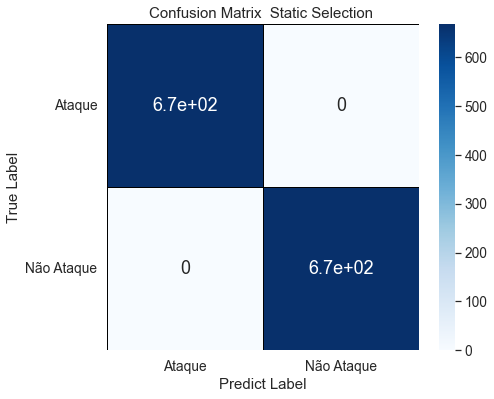

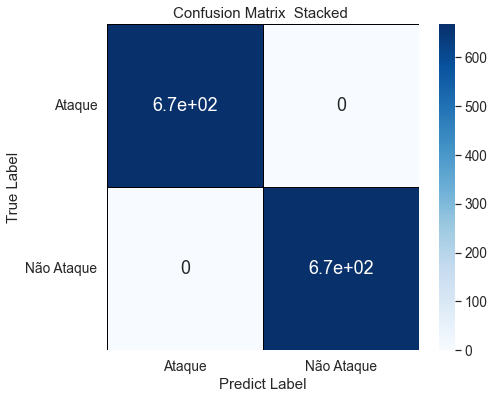

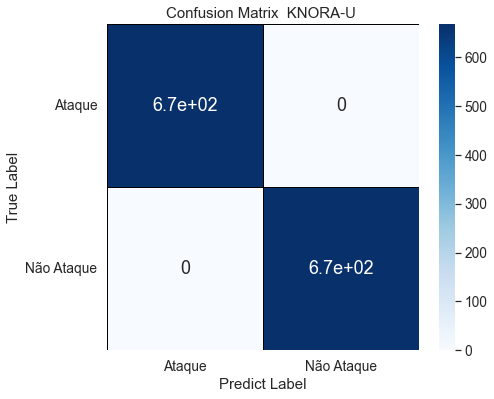

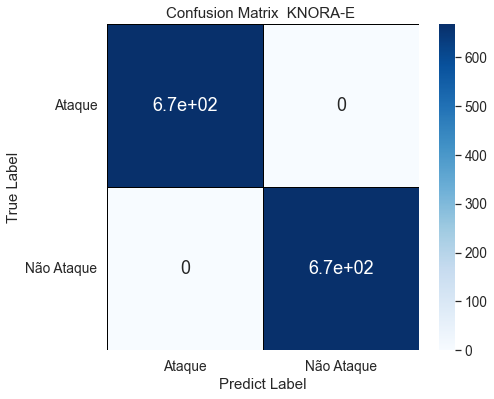

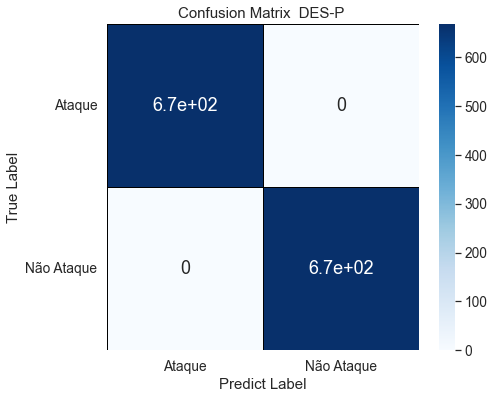

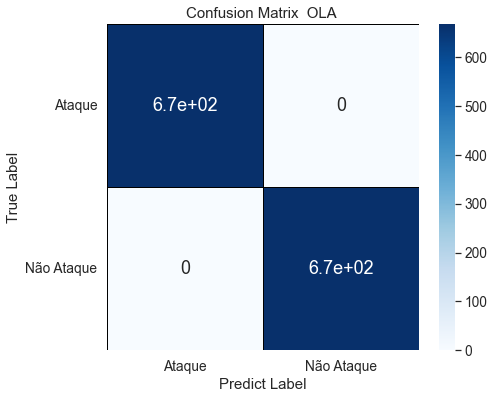

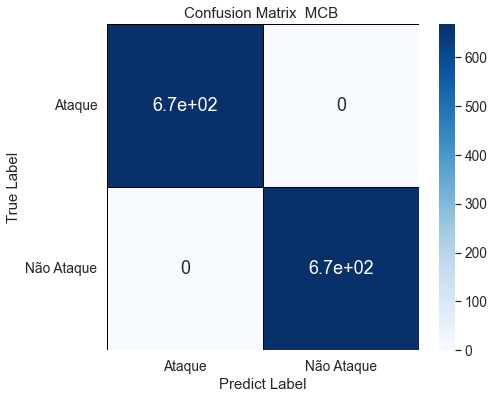

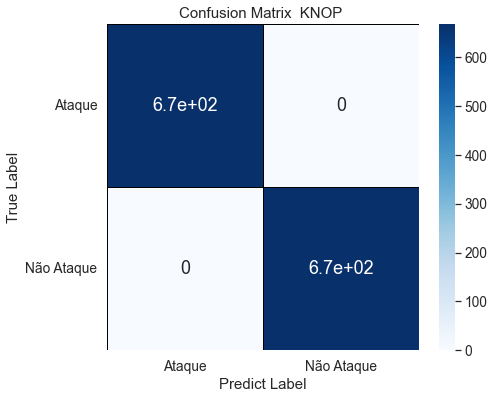

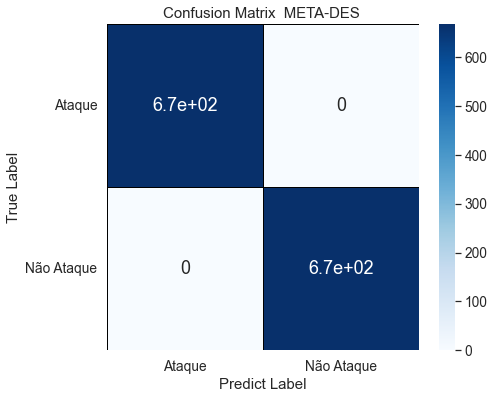

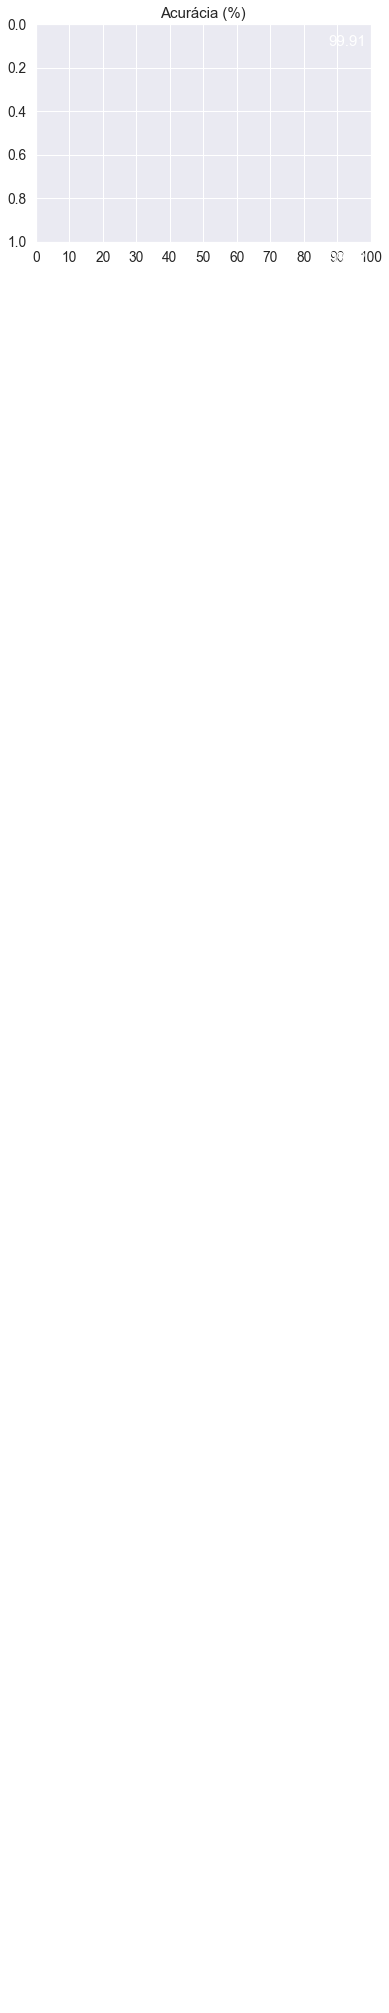

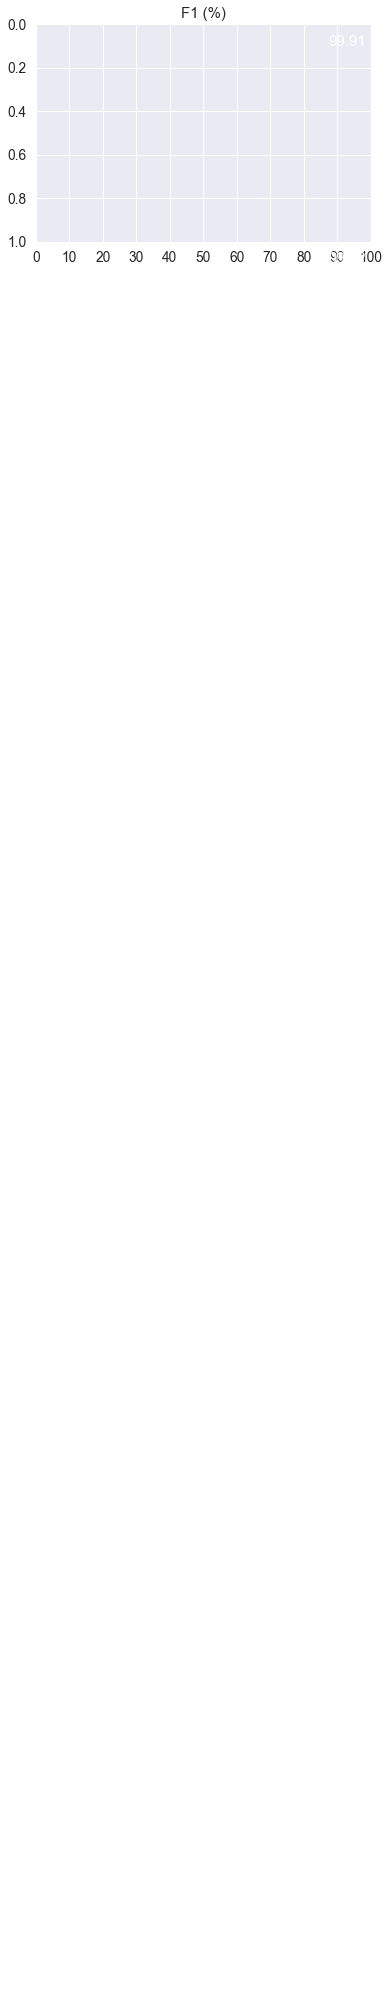

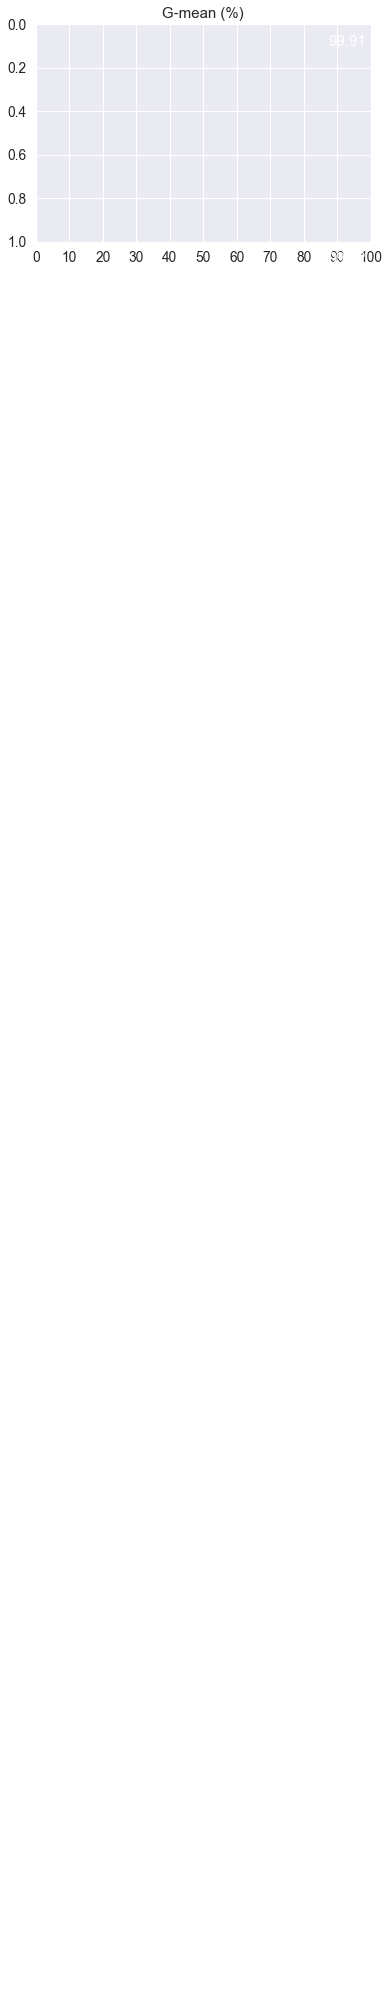

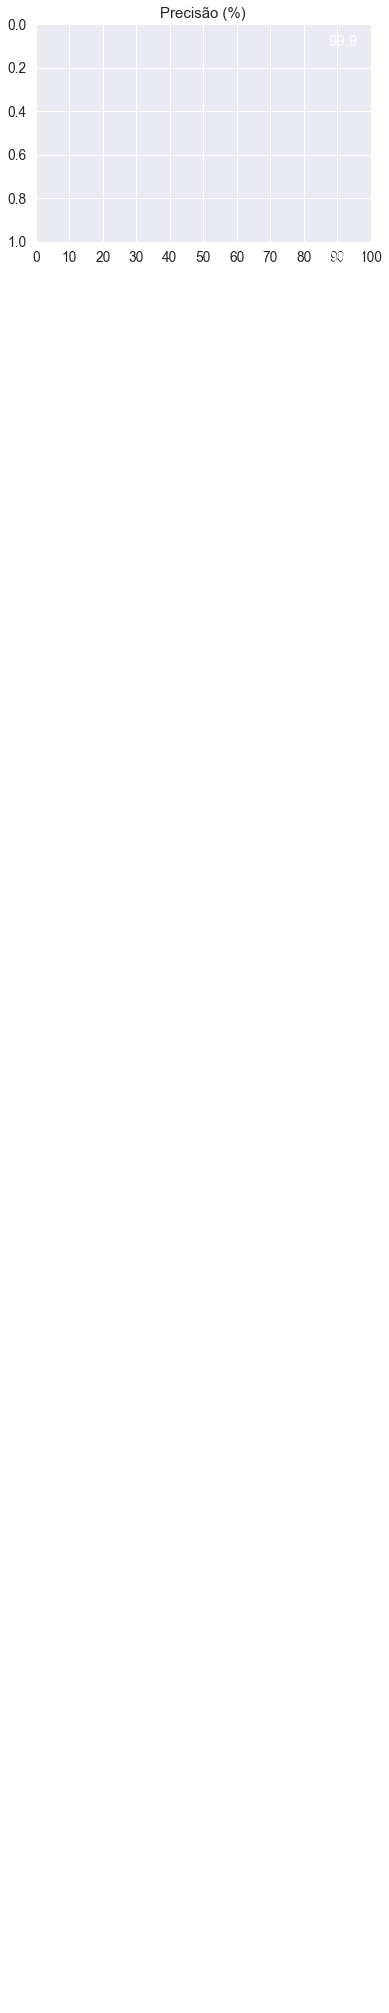

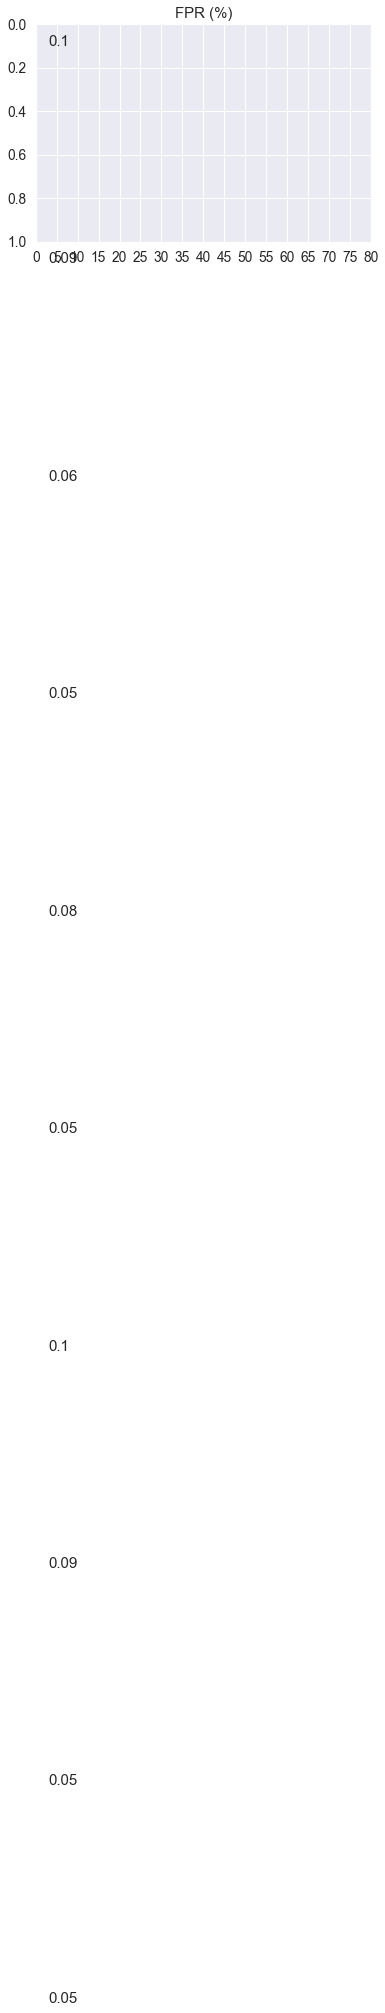

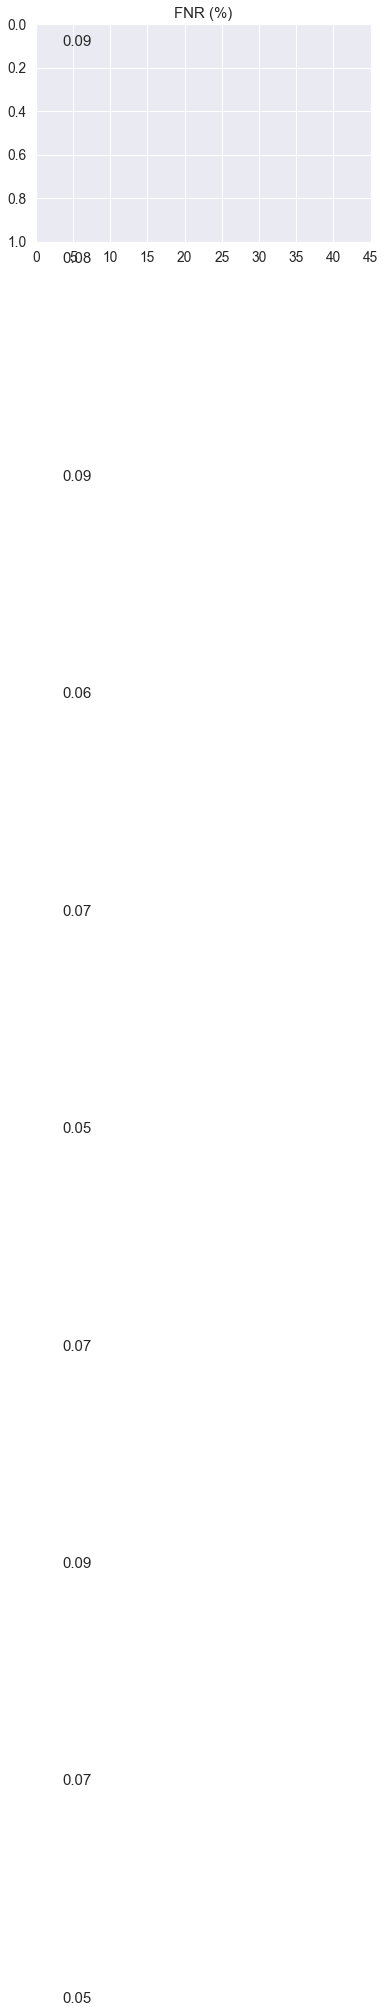

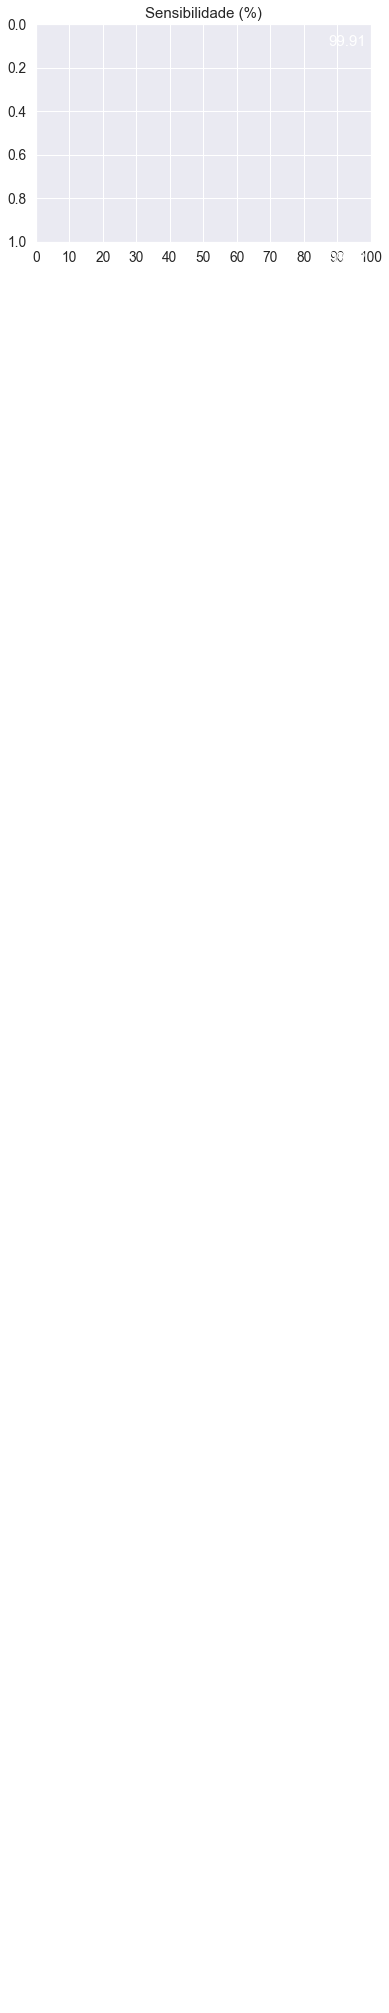

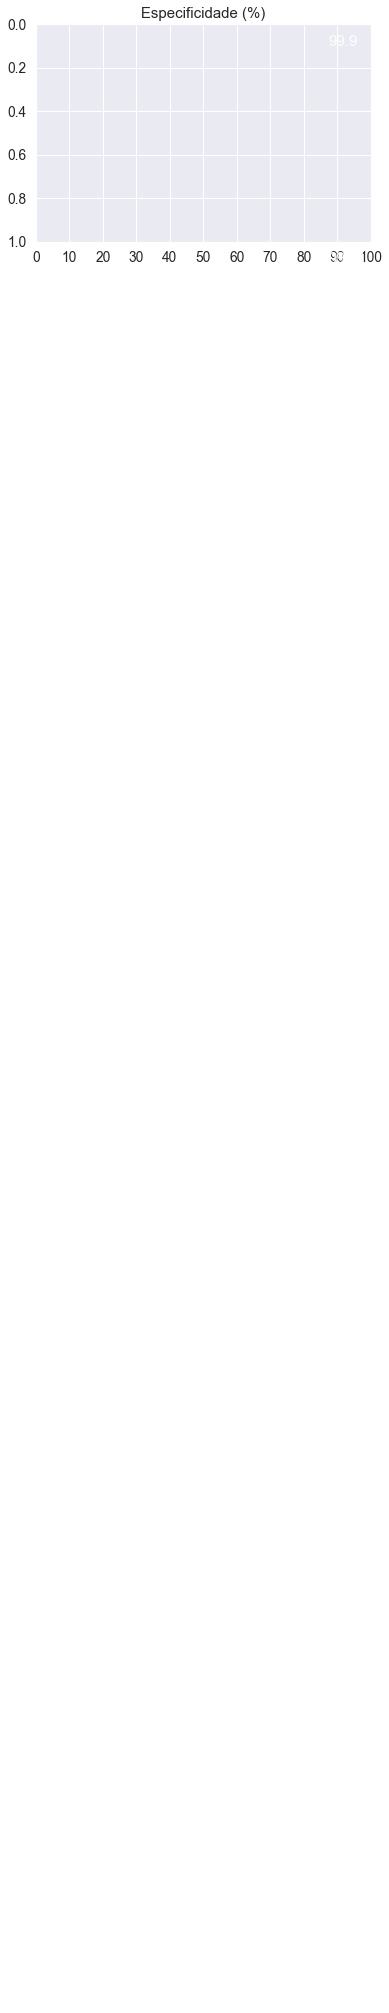

In [244]:
# Variáveis auxiliares
Acu_csv = pd.DataFrame()
F1_csv = pd.DataFrame()
Prec_csv = pd.DataFrame()
FPR_csv = pd.DataFrame()
FNR_csv = pd.DataFrame()
Sens_csv = pd.DataFrame()
Espec_csv = pd.DataFrame()
integra = pd.DataFrame()

cont = 0
int_conf = pd.DataFrame()
metricas = pd.DataFrame()
count = 0

for m in metodos:
    
    # Variáveis auxiliares
    acuracia_total = []
    f1_total = []
    precisao_total = []
    fpr_total = []
    fnr_total = []
    sens_total = []
    espec_total = []
    gmean_total = []

    matr1 = []
    matr2 = []
    matr3 = []
    matr4 = []
    contador = 0


    for c in range(10):
        # Divisão em treinamento e teste
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=c)
        
        # Variáveis auxiliares
        iteracao2 = []
        f1 = []
        precisao = []
        fnr_parc = []
        fpr_parc = []
        sens_parc = []
        espec_parc = []
        gmean_parc = []
        #print(iteracao2, f1, precisao, fnr_parc, fpr_parc, sens_parc, espec_parc, gmean_parc, )

        # Instanciamento dos classificadores
        for indice_treinamento, indice_teste in kfold.split(x_rus, np.zeros(shape=(y_rus.shape[0], 1))):
            
            # Treinamento dos classificadores
            m.fit(x_rus[indice_treinamento], y_rus[indice_treinamento])
            xyz = y_rus[indice_teste]
            previsoes = m.predict(x_rus[indice_teste])
            
            # Análise dos resultados
            acuracia = accuracy_score(y_rus[indice_teste], previsoes)*100
            matriz = confusion_matrix(y_rus[indice_teste], previsoes, labels = [1, 0] )
            f1_parcial = f1_score(y_rus[indice_teste], previsoes)*100
            precisao_parcial = precision_score(y_rus[indice_teste], previsoes)*100
            mat1 = matriz[0,0]
            mat2 = matriz[0,1]
            mat3 = matriz[1,0]
            mat4 = matriz[1,1]
            fpr = matriz[1,0]/(matriz[1,0]+matriz[1,1])*100
            fnr = matriz[0,1]/(matriz[0,1]+matriz[0,0])*100
            sens = matriz[0,0]/(matriz[0,0]+matriz[0,1])*100
            espec = matriz[1,1]/(matriz[1,1]+matriz[1,0])*100
            gmean = sqrt(sens*espec)
            
            # Preenchimento dos vetores de dados
            iteracao2.append(acuracia)
            matr1.append(mat1)
            matr2.append(mat2)
            matr3.append(mat3)
            matr4.append(mat4)
            f1.append(f1_parcial)
            precisao.append(precisao_parcial)
            fnr_parc.append(fnr)
            fpr_parc.append(fpr)
            sens_parc.append(sens)
            espec_parc.append(espec)
            gmean_parc.append(gmean)  
        
        iteracao2 = np.asarray(iteracao2)
        media = iteracao2.mean()
        acuracia_total.append(media)
        
        f1 = np.asarray(f1)
        mediaf1 = f1.mean()
        f1_total.append(mediaf1)
        
        precisao = np.asarray(precisao)
        mediaprec = precisao.mean()
        precisao_total.append(mediaprec)
        
        fnr_parc = np.asarray(fnr_parc)
        media_fnr = fnr_parc.mean()
        fnr_total.append(media_fnr)
        
        fpr_parc = np.asarray(fpr_parc)
        media_fpr = fpr_parc.mean()
        fpr_total.append(media_fpr)
        
        sens_parc = np.asarray(sens_parc)
        media_sens = sens_parc.mean()
        sens_total.append(media_sens)
        
        espec_parc = np.asarray(espec_parc)
        media_espec = espec_parc.mean()
        espec_total.append(media_espec)
        
        gmean_total.append(mean(gmean_parc))

        #print(iteracao2, f1, precisao, fnr_parc, fpr_parc, sens_parc, espec_parc, gmean_parc )   
        #print(acuracia_total, f1_total,precisao_total,fnr_total,fpr_total,sens_total,espec_total, gmean_total)

    #seleção e integração nao treinavel
    Acu_csv[m] = acuracia_total
    F1_csv[m] = f1_total
    Prec_csv[m] = precisao_total
    FPR_csv[m] = fpr_total
    FNR_csv[m] = fnr_total
    Sens_csv[m] = sens_total
    Espec_csv[m] = espec_total
    matriz_final = np.array([[mean(matr1), mean(matr2)],[mean(matr3), mean(matr4)]])
        
        
    #print("-------M--------")
    #print(Acu_csv, F1_csv, Prec_csv, FPR_csv, FNR_csv, Sens_csv, Espec_csv, matriz_final,integra ) 

    # Plotagem da matriz de confusão
    x = ['Ataque', 'Não Ataque']
    y = ['Ataque', 'Não Ataque']
    cm = pd.DataFrame(matriz_final, x, y)
    fig = plt.figure(figsize=(7,6))
    sns.set(font_scale=1.25)
    mapa = sns.heatmap(cm, annot=True, annot_kws={"size": 18}, cmap='Blues', 
                        linewidths=1, linecolor="black")
    mapa.set_yticklabels(mapa.get_yticklabels(), rotation=0)
    plt.xlabel("Predict Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix  {} "  .format(metodos2[cont]))
    plt.savefig(r'C:\Users\anali\OneDrive\Documentos\Faculdade\TCC\Treinamento2\Metricas\matrix\{}.png'.format(metodos2[cont]), bbox_inches="tight", dpi=100)
    cont+=1

    # Valores das métricas com intervalo de confiança
    teste = (acuracia_total, f1_total, gmean_total, precisao_total, fpr_total, fnr_total, sens_total, espec_total)
    for t in teste:
        int_conf.loc[metodos2[count], contador] = stdev(t)
        metricas.loc[metodos2[count], contador] = round(mean(t), 2)
        contador+=1
    #print(teste)
    count+=1

# Renomeando as colunas das matrizes das métricas
int_conf.columns = ['Acuracia', 'F1', 'G-mean', 'Precisao', 'FPR', 'FNR', 'Sensibilidade', 'Especificidade']
metricas.columns = ['Acuracia', 'F1', 'G-mean', 'Precisao', 'FPR', 'FNR', 'Sensibilidade', 'Especificidade']

# Chamada das funções de plotagem dos gráficos das métricas e de geração dos arquivos CSV com os dados 
salvar_grafico(metricas, int_conf)
csvs = (Acu_csv, F1_csv, Prec_csv, FPR_csv, FNR_csv, Sens_csv, Espec_csv)
for doc in csvs:
    gerar_csv(doc)



